**Problem statement**: To build a CNN based model which can accurately detect melanoma. Melanoma is a type of cancer that can be deadly if not detected early. It accounts for 75% of skin cancer deaths. A solution which can evaluate images and alert the dermatologists about the presence of melanoma has the potential to reduce a lot of manual effort needed in diagnosis.


**Importing all the important libraries**

In [3]:
import pathlib
import tensorflow as tf
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
from glob import glob
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential



In [4]:

from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


**Importing Skin Cancer Data**

To do: Take necessary actions to read the data

In [5]:
# Defining the path for train and test images)
train_set = pathlib.Path('/content/gdrive/MyDrive/archive/Skin cancer ISIC The International Skin Imaging Collaboration/Train')
test_set = pathlib.Path('/content/gdrive/MyDrive/archive/Skin cancer ISIC The International Skin Imaging Collaboration/Test')

This assignment uses a dataset of about 2357 images of skin cancer types. The dataset contains 9 sub-directories in each train and test subdirectories. The 9 sub-directories contains the images of 9 skin cancer types respectively.



In [6]:
train_img_count = len(list(train_set.glob('*/*.jpg')))

print(train_img_count)

test_img_count = len(list(test_set.glob('*/*.jpg')))

print(test_img_count)

2239
118


**Load using keras.preprocessing**

Let's load these images off disk using the helpful image_dataset_from_directory utility.







In [7]:
from tensorflow.keras.preprocessing import image_dataset_from_directory

# Define the directory containing the images
## Note use seed=123 while creating your dataset using tf.keras.preprocessing.image_dataset_from_directory
## Note, make sure your resize your images to the size img_height*img_width, while writting the dataset
directory = train_set

# Create a dataset from the directory
training_dataset = image_dataset_from_directory(
    directory,
    batch_size=32,
    image_size=(180, 180),
    seed = 123,
    shuffle=True,
    validation_split=0.2,
    subset='training'
)

# Print class names
class_names = training_dataset.class_names
print("Class names:", class_names)


Found 2239 files belonging to 9 classes.
Using 1792 files for training.
Class names: ['actinic keratosis', 'basal cell carcinoma', 'dermatofibroma', 'melanoma', 'nevus', 'pigmented benign keratosis', 'seborrheic keratosis', 'squamous cell carcinoma', 'vascular lesion']


In [8]:
# Load the validation subset of the dataset
## Note use seed=123 while creating your dataset using tf.keras.preprocessing.image_dataset_from_directory
## Note, make sure your resize your images to the size img_height*img_width, while writting the dataset
validation_dataset = image_dataset_from_directory(
    directory,
    batch_size=32,
    seed = 123,
    image_size=(180,180),
    shuffle=True,
    validation_split=0.2,
    subset='validation')  # Load the validation subset

Found 2239 files belonging to 9 classes.
Using 447 files for validation.


**Visualize the data**

Let's visualize one instance of all the nine classes present in the dataset.

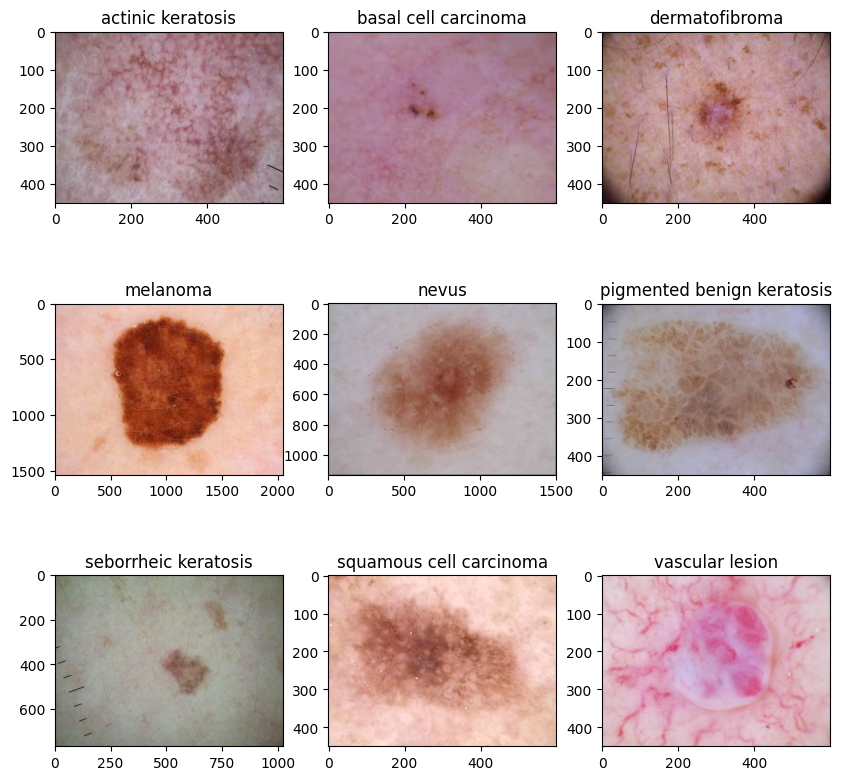

In [9]:
import matplotlib.pyplot as plt

plt.figure(figsize=[10, 10])

for i in range(9):
    plt.subplot(3, 3, i + 1)
    image = plt.imread(str(list(train_set.glob(class_names[i] + '/*.jpg'))[1]))
    plt.title(class_names[i])
    plt.imshow(image)  # Show the image within each subplot

plt.show()  # Display the entire figure containing the subplots



The `image_batch` is a tensor of the shape `(32, 180, 180, 3)`. This is a batch of 32 images of shape `180x180x3` (the last dimension refers to color channels RGB). The `label_batch` is a tensor of the shape `(32,)`, these are corresponding labels to the 32 images.

`Dataset.cache()` keeps the images in memory after they're loaded off disk during the first epoch.

`Dataset.prefetch()` overlaps data preprocessing and model execution while training.

In [10]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
training_dataset = training_dataset.cache().shuffle(1000).prefetch(buffer_size = AUTOTUNE)
validation_dataset = validation_dataset.cache().prefetch(buffer_size = AUTOTUNE)

This code sets up training and validation datasets for a machine learning model, applies **caching**, **shuffling**, and prefetching to optimize data loading and improve training performance. The **AUTOTUNE** constant is used to automatically tune certain parameters, such as the prefetch buffer size, for `optimal performance`.




**Create the model**

Creating a CNN model, which can accurately detect 9 classes present in the dataset. Using **layers.experimental.preprocessing.Rescaling** to normalize pixel values between `(0,1)`. The RGB channel values are in the `[0, 255]` range. This is not ideal for a neural network. Hence, it is good to standardize values to be in the `[0, 1]`


In [11]:
from keras.layers import Dense, Flatten, Conv2D, MaxPooling2D

num_classes = len(class_names)
img_height = 180
img_width = 180

model = Sequential([
  layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])


**Compile the model**

Choosing an appropirate optimiser and loss function for model training

In [12]:
from keras.losses import SparseCategoricalCrossentropy
model.compile(optimizer = 'adam', loss = SparseCategoricalCrossentropy(from_logits = True),
              metrics = 'accuracy')

**Summary of all the layers**

In [13]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 180, 180, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 180, 180, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2  (None, 90, 90, 16)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 90, 90, 32)        4640      
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 45, 45, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 45, 45, 64)        1

**Train the model**


In [14]:
epochs = 20
history = model.fit(
  training_dataset,
  validation_data = validation_dataset,
  epochs=epochs
)

Epoch 1/20
56/56 [==============================] - 415s 2s/step - loss: 2.0194 - accuracy: 0.2316 - val_loss: 1.9403 - val_accuracy: 0.2774
Epoch 2/20
56/56 [==============================] - 2s 30ms/step - loss: 1.8844 - accuracy: 0.3097 - val_loss: 1.8088 - val_accuracy: 0.3826
Epoch 3/20
56/56 [==============================] - 1s 26ms/step - loss: 1.6341 - accuracy: 0.4286 - val_loss: 1.5320 - val_accuracy: 0.4474
Epoch 4/20
56/56 [==============================] - 1s 24ms/step - loss: 1.3997 - accuracy: 0.4888 - val_loss: 1.5757 - val_accuracy: 0.4609
Epoch 5/20
56/56 [==============================] - 1s 21ms/step - loss: 1.3008 - accuracy: 0.5452 - val_loss: 1.5010 - val_accuracy: 0.4944
Epoch 6/20
56/56 [==============================] - 1s 20ms/step - loss: 1.2642 - accuracy: 0.5580 - val_loss: 1.4499 - val_accuracy: 0.5414
Epoch 7/20
56/56 [==============================] - 1s 21ms/step - loss: 1.1587 - accuracy: 0.5831 - val_loss: 1.4316 - val_accuracy: 0.5593
Epoch 8/20
56

**Visualizing training results**

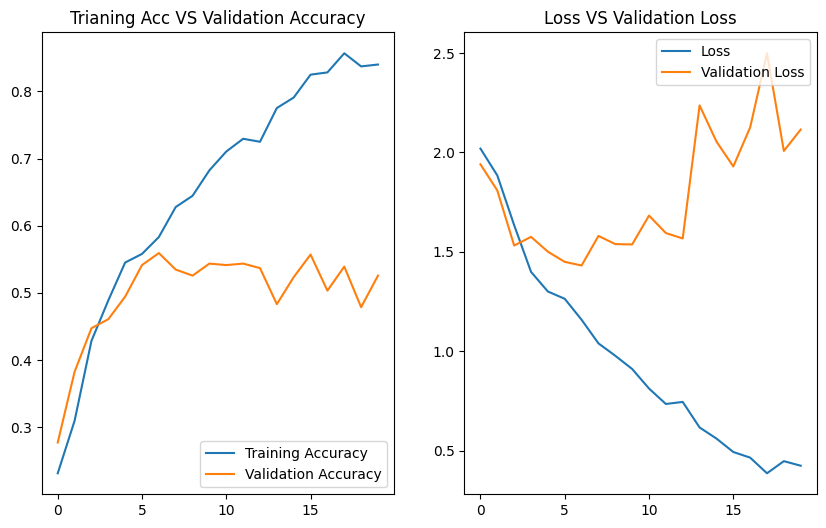

In [15]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize = [10,6])
plt.subplot(1,2,1)
plt.plot(epochs_range, acc, label = 'Training Accuracy')
plt.plot(epochs_range, val_acc, label = 'Validation Accuracy' )
plt.legend(loc = 'lower right')
plt.title('Trianing Acc VS Validation Accuracy')



plt.subplot(1,2,2)
plt.plot(epochs_range, loss, label = 'Loss')
plt.plot(epochs_range, val_loss, label = 'Validation Loss')
plt.legend(loc = 'upper right')
plt.title('Loss VS Validation Loss')

plt.show()

**Findings:**

1] We can clearly observe a drastic difference between Traning and Validation Accuracy, which indicates that the model has overfitted

2] Also we can observe that the validation accuracy the model has achieved is below 50 %

Overall we need to apply techniques like `Data Augmentation` and `Dropout` to handle the overfitting issue of the model

In [16]:
data_augmentation = keras.Sequential(
  [
    layers.RandomFlip("horizontal",
                      input_shape=(img_height,
                                  img_width,
                                  3)),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
  ]
)

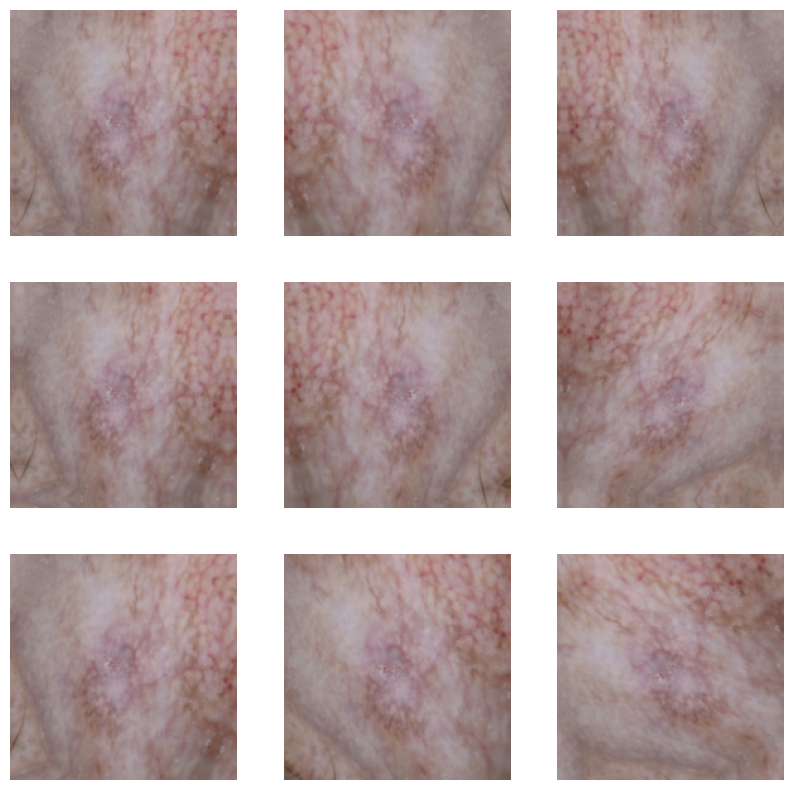

In [17]:
plt.figure(figsize=(10, 10))
for images, _ in training_dataset.take(1):
  for i in range(9):
    augmented_images = data_augmentation(images)
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_images[0].numpy().astype("uint8"))
    plt.axis("off")

Create the model, compile and train the model

In [18]:
model = Sequential([
  data_augmentation,
  layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

Compiling the model

In [19]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

Training the model


In [20]:
history = model.fit(
  training_dataset,
  validation_data=validation_dataset,
  epochs=epochs
)

Epoch 1/20
56/56 [==============================] - 5s 34ms/step - loss: 1.9605 - accuracy: 0.2868 - val_loss: 1.8203 - val_accuracy: 0.3445
Epoch 2/20
56/56 [==============================] - 2s 30ms/step - loss: 1.7068 - accuracy: 0.3672 - val_loss: 1.6930 - val_accuracy: 0.3870
Epoch 3/20
56/56 [==============================] - 2s 32ms/step - loss: 1.5550 - accuracy: 0.4302 - val_loss: 1.4723 - val_accuracy: 0.4855
Epoch 4/20
56/56 [==============================] - 2s 31ms/step - loss: 1.4383 - accuracy: 0.4916 - val_loss: 1.4320 - val_accuracy: 0.4989
Epoch 5/20
56/56 [==============================] - 2s 29ms/step - loss: 1.3723 - accuracy: 0.5296 - val_loss: 1.4639 - val_accuracy: 0.5302
Epoch 6/20
56/56 [==============================] - 2s 29ms/step - loss: 1.3094 - accuracy: 0.5290 - val_loss: 1.3664 - val_accuracy: 0.5078
Epoch 7/20
56/56 [==============================] - 2s 29ms/step - loss: 1.3153 - accuracy: 0.5318 - val_loss: 1.3434 - val_accuracy: 0.5190
Epoch 8/20
56

Visualizing the results


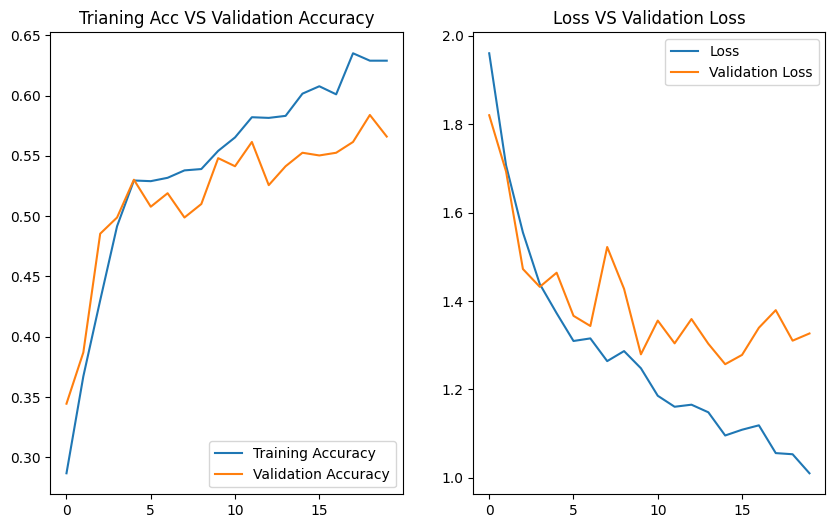

In [21]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize = [10,6])
plt.subplot(1,2,1)
plt.plot(epochs_range, acc, label = 'Training Accuracy')
plt.plot(epochs_range, val_acc, label = 'Validation Accuracy' )
plt.legend(loc = 'lower right')
plt.title('Trianing Acc VS Validation Accuracy')



plt.subplot(1,2,2)
plt.plot(epochs_range, loss, label = 'Loss')
plt.plot(epochs_range, val_loss, label = 'Validation Loss')
plt.legend(loc = 'upper right')
plt.title('Loss VS Validation Loss')

plt.show()

**Findings:**

As we can see that now the Training and Validation accuracy are almost in the same level and the highest accuracy achieved is around `60% `, this shows the impact of how performing **Data Augmentation** can improve the model performance

But we should still try to increase the accuracy of the model


**Find the distribution of classes in the training dataset**.

**Context**: Many times real life datasets can have class imbalance, one class can have proportionately higher number of samples compared to the others. Class imbalance can have a detrimental effect on the final model quality. Hence as a sanity check it becomes important to check what is the distribution of classes in the data.

In [22]:
path_list = [x for x in glob(os.path.join(train_set, '*', '*.jpg'))]
lesion_list = [os.path.basename(os.path.dirname(y)) for y in glob(os.path.join(train_set, '*', '*.jpg'))]
dataframe_dict_original = dict(zip(path_list, lesion_list))
df = pd.DataFrame(list(dataframe_dict_original.items()),columns = ['Path','Label'])
df

,Path,Label
0,/content/gdrive/MyDrive/archive/Skin cancer IS...,vascular lesion
1,/content/gdrive/MyDrive/archive/Skin cancer IS...,vascular lesion
2,/content/gdrive/MyDrive/archive/Skin cancer IS...,vascular lesion
3,/content/gdrive/MyDrive/archive/Skin cancer IS...,vascular lesion
4,/content/gdrive/MyDrive/archive/Skin cancer IS...,vascular lesion
...,...,...
2234,/content/gdrive/MyDrive/archive/Skin cancer IS...,nevus
2235,/content/gdrive/MyDrive/archive/Skin cancer IS...,nevus
2236,/content/gdrive/MyDrive/archive/Skin cancer IS...,nevus
2237,/content/gdrive/MyDrive/archive/Skin cancer IS...,nevus


Class=8, n=139 (6.21%)
Class=0, n=114 (5.09%)
Class=3, n=438 (19.56%)
Class=1, n=376 (16.79%)
Class=6, n=77 (3.44%)
Class=7, n=181 (8.08%)
Class=5, n=462 (20.63%)
Class=2, n=95 (4.24%)
Class=4, n=357 (15.94%)


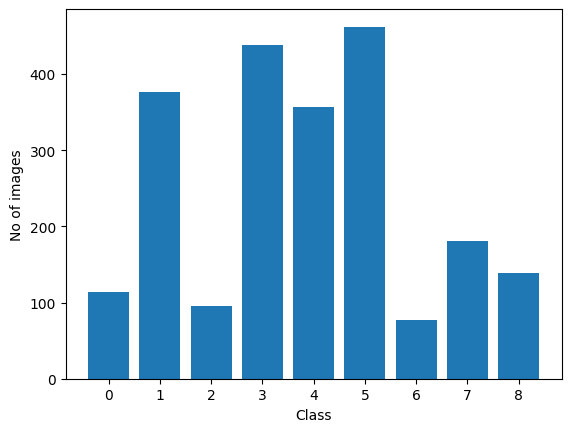

In [27]:
from sklearn.preprocessing import LabelEncoder
from collections import Counter

X, y = df['Path'], df['Label']
y = LabelEncoder().fit_transform(y)
counter = Counter(y)
for k,v in counter.items():
	per = v / len(y) * 100
	print('Class=%d, n=%d (%.2f%%)' % (k, v, per))

plt.bar(counter.keys(), counter.values())
plt.xticks([i for i in range(9)])
plt.xlabel("Class")
plt.ylabel("No of images")
plt.show()

**Write your findings here:**

- Which class has the least number of samples?

Ans] From the above bar chart we can see that the class with label 6 has the least number of samples

- Which classes dominate the data in terms proportionate number of samples?

Ans] We can observe that of all the class, class with label 5 has the most number of samples

**Rectify the class imbalance**

**Context**: You can use a python package known as Augmentor (https://augmentor.readthedocs.io/en/master/) to add more samples across all classes so that none of the classes have very few samples.

In [24]:
!pip install Augmentor

To use Augmentor, the following general procedure is followed:

Instantiate a Pipeline object pointing to a directory containing initial image data set.
Define a number of operations to perform on this data set using Pipeline object.
Execute these operations by calling the Pipeline’s sample() method.

In [28]:
# Define input and output directories
input_base_dir = '/content/gdrive/MyDrive/archive/Skin cancer ISIC The International Skin Imaging Collaboration/Train'
output_base_dir = '/content/output'  # Change this to your desired output directory path
import Augmentor
# Loop through class names
for class_name in class_names:
    input_dir = os.path.join(input_base_dir, class_name)
    output_dir = os.path.join(output_base_dir, class_name, 'output')

    # Create a pipeline for each class
    p = Augmentor.Pipeline(source_directory=input_dir, output_directory=output_dir)
    p.rotate(probability=0.7, max_left_rotation=10, max_right_rotation=10)
    p.sample(500)  # We are adding 500 samples per class to make sure that none of the classes are sparse.

Initialised with 114 image(s) found.
Output directory set to /content/output/actinic keratosis/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x7A43DF7D38B0>: 100%|██████████| 500/500 [00:20<00:00, 24.94 Samples/s]


Initialised with 376 image(s) found.
Output directory set to /content/output/basal cell carcinoma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7A44606A4790>: 100%|██████████| 500/500 [00:16<00:00, 30.05 Samples/s]


Initialised with 95 image(s) found.
Output directory set to /content/output/dermatofibroma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7A44601AAEC0>: 100%|██████████| 500/500 [00:19<00:00, 25.46 Samples/s]


Initialised with 438 image(s) found.
Output directory set to /content/output/melanoma/output.

Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x7A43DF62E380>: 100%|██████████| 500/500 [01:25<00:00,  5.84 Samples/s]


Initialised with 357 image(s) found.
Output directory set to /content/output/nevus/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=919x802 at 0x7A43DF66F580>: 100%|██████████| 500/500 [01:12<00:00,  6.88 Samples/s]


Initialised with 462 image(s) found.
Output directory set to /content/output/pigmented benign keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7A447BC12470>: 100%|██████████| 500/500 [00:16<00:00, 29.49 Samples/s]


Initialised with 77 image(s) found.
Output directory set to /content/output/seborrheic keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x7A447C5AB520>: 100%|██████████| 500/500 [00:37<00:00, 13.18 Samples/s]


Initialised with 181 image(s) found.
Output directory set to /content/output/squamous cell carcinoma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7A43EE6DE890>: 100%|██████████| 500/500 [00:17<00:00, 28.63 Samples/s]


Initialised with 139 image(s) found.
Output directory set to /content/output/vascular lesion/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7A447BC12E60>: 100%|██████████| 500/500 [00:19<00:00, 25.93 Samples/s]


Augmentor has stored the augmented images in the output sub-directory of each of the sub-directories of skin cancer types.. Lets take a look at total count of augmented images.

In [29]:
output_dir = pathlib.Path('/content/output')


In [30]:
image_count_train = len(list(output_dir.glob('*/output/*.jpg')))
print(image_count_train)

4500


Lets see the distribution of augmented data after adding new images to the original training data.

In [31]:
path_list = [x for x in glob(os.path.join(output_dir, '*','output', '*.jpg'))]
path_list[:5]

['/content/output/nevus/output/nevus_original_ISIC_0000237.jpg_d9027ad3-af10-4051-9f6b-3a986942e997.jpg',
 '/content/output/nevus/output/nevus_original_ISIC_0000435.jpg_91e6ff26-5f51-4200-93ea-102717c806c1.jpg',
 '/content/output/nevus/output/nevus_original_ISIC_0000322.jpg_fdb32090-5d64-4e78-9aeb-9bf1d8fc8b29.jpg',
 '/content/output/nevus/output/nevus_original_ISIC_0000535.jpg_a3d4a22b-10f4-4b4a-ad4b-68c2b928704b.jpg',
 '/content/output/nevus/output/nevus_original_ISIC_0000097.jpg_0ff183cf-8edc-4605-98ce-bb7845ccead6.jpg']

In [32]:
lesion_list_new = [os.path.basename(os.path.dirname(os.path.dirname(y))) for y in glob(os.path.join(output_dir, '*','output', '*.jpg'))]
lesion_list_new[:5]

['nevus', 'nevus', 'nevus', 'nevus', 'nevus']

In [33]:
dataframe_dict_new = dict(zip(path_list, lesion_list_new))

In [34]:
df2 = pd.DataFrame(list(dataframe_dict_new.items()),columns = ['Path','Label'])
new_df = df._append(df2)

In [35]:
new_df['Label'].value_counts()

Label
pigmented benign keratosis    962
melanoma                      938
basal cell carcinoma          876
nevus                         857
squamous cell carcinoma       681
vascular lesion               639
actinic keratosis             614
dermatofibroma                595
seborrheic keratosis          577
Name: count, dtype: int64

Now we have added 500 images to all the classes to maintain some class balance. We can add more images as we want to improve training process.


**Train the model on the data created using Augmentor**

In [36]:
batch_size = 32
img_height = 180
img_width = 180

Create a training dataset

In [41]:
train_ds = image_dataset_from_directory(
  train_set,
  seed=123,
  validation_split = 0.2,
  subset = "training",
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 2239 files belonging to 9 classes.
Using 1792 files for training.


Create a validation dataset

In [42]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  train_set,
  seed=123,
  validation_split = 0.2,
  subset = "validation",
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 2239 files belonging to 9 classes.
Using 447 files for validation.


Create your model (make sure to include normalization)

In [43]:
model = Sequential([
  data_augmentation,
  layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

Compile your model (Choose optimizer and loss function appropriately)

In [44]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

**Train your model**

In [ ]:
epochs = 30
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/30
56/56 [==============================] - 23s 298ms/step - loss: 2.0333 - accuracy: 0.2812 - val_loss: 1.7402 - val_accuracy: 0.3557
Epoch 2/30
56/56 [==============================] - 19s 312ms/step - loss: 1.7214 - accuracy: 0.3633 - val_loss: 1.7169 - val_accuracy: 0.3669
Epoch 3/30
56/56 [==============================] - 21s 339ms/step - loss: 1.6442 - accuracy: 0.3940 - val_loss: 1.5581 - val_accuracy: 0.4497
Epoch 4/30
56/56 [==============================] - 22s 368ms/step - loss: 1.5252 - accuracy: 0.4559 - val_loss: 1.4741 - val_accuracy: 0.4787
Epoch 5/30
56/56 [==============================] - 20s 324ms/step - loss: 1.4408 - accuracy: 0.4838 - val_loss: 1.4223 - val_accuracy: 0.4743
Epoch 6/30
56/56 [==============================] - 19s 301ms/step - loss: 1.3926 - accuracy: 0.4916 - val_loss: 1.3780 - val_accuracy: 0.5280
Epoch 7/30
56/56 [==============================] - 19s 302ms/step - loss: 1.3202 - accuracy: 0.5335 - val_loss: 1.3544 - val_accuracy: 0.5056

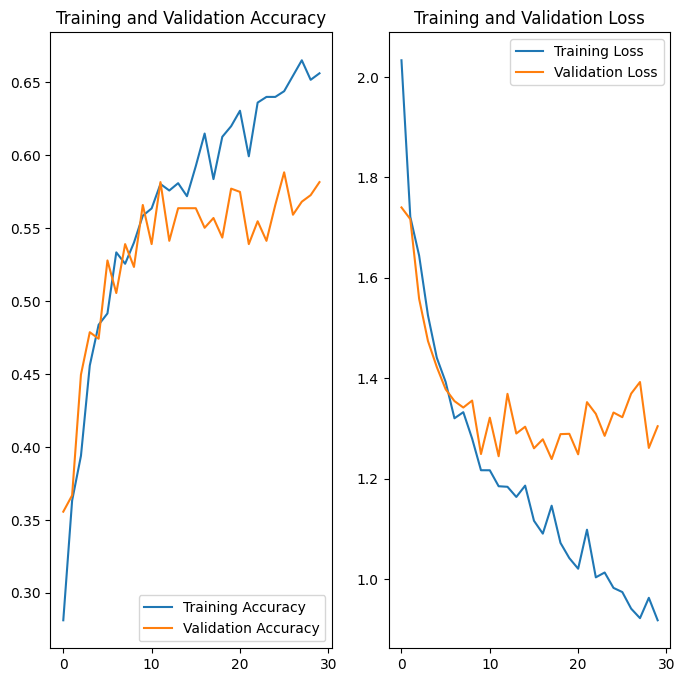

In [46]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

**Analyze your results here. Did you get rid of underfitting/overfitting? Did class rebalance help?**


Findings:
We can infer that the Model is fit with a good enough accuracy for both Train and Validation Data of max accuracy around 85% Rectifying the Class Imbalance and performing Data augumentation on the dataset has resulted in a model with higher accuracy and overcoming overfitting This is a good model to be used to predict Skin Cancer using CNN